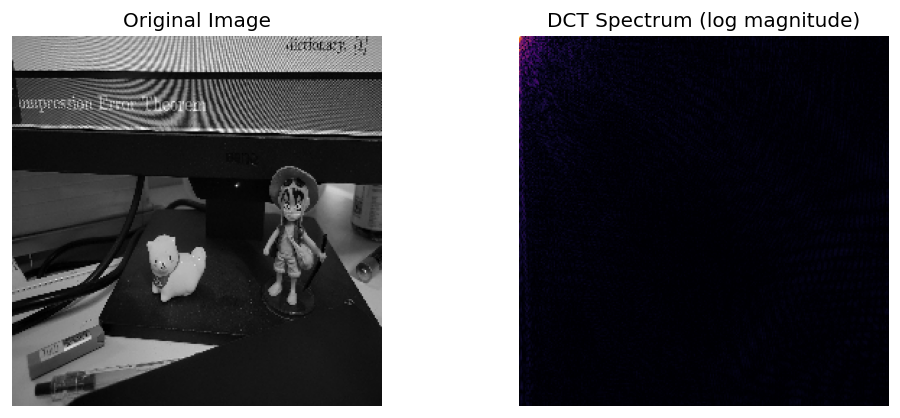

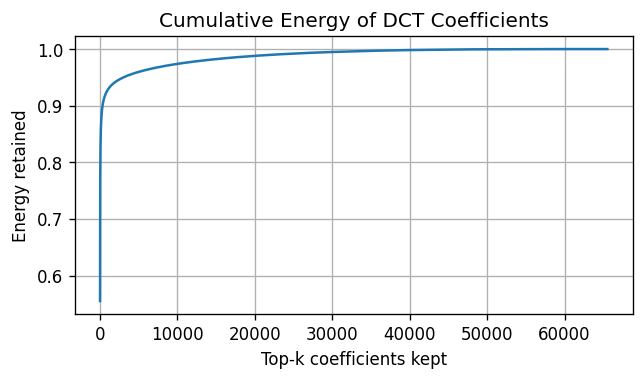

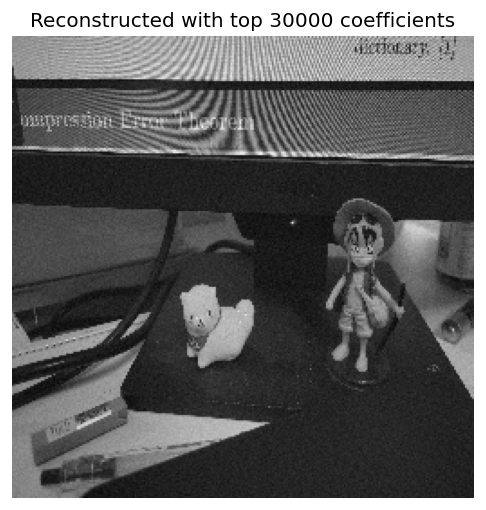

In [1]:
# slide 10
import numpy as np
import matplotlib.pyplot as plt
import cv2

plt.rcParams['figure.dpi'] = 120

def dct2(a):
    return cv2.dct(np.float32(a))

def idct2(a):
    return cv2.idct(np.float32(a))

def show_dct_energy(img_path, keep=2000):
    # load + grayscale + resize for clarity
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256,256))
    I = img.astype(np.float32) / 255.0

    # Compute 2D DCT
    C = dct2(I)

    # Show magnitude spectrum (log for visibility)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].imshow(I, cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(np.log(1+np.abs(C)), cmap='inferno')
    ax[1].set_title("DCT Spectrum (log magnitude)")
    ax[1].axis('off')
    plt.show()

    # Flatten and sort coefficients by magnitude
    flat = np.abs(C).flatten()
    idx = np.argsort(flat)[::-1]

    # cumulative energy
    energy = flat[idx]**2
    cum_energy = np.cumsum(energy) / np.sum(energy)

    plt.figure(figsize=(6,3))
    plt.plot(cum_energy)
    plt.title("Cumulative Energy of DCT Coefficients")
    plt.xlabel("Top-k coefficients kept")
    plt.ylabel("Energy retained")
    plt.grid(True)
    plt.show()

    # Reconstruct with top-k
    Ck = np.zeros_like(C).flatten()
    Ck[idx[:keep]] = C.flatten()[idx[:keep]]
    Ck = Ck.reshape(C.shape)

    Ik = idct2(Ck)

    plt.figure(figsize=(5,5))
    plt.imshow(Ik, cmap='gray')
    plt.title(f"Reconstructed with top {keep} coefficients")
    plt.axis('off')
    plt.show()

show_dct_energy("raw_image.jpg", keep=30000)

In [2]:
# Slide 10,11 

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Checkbox, VBox, HBox, Layout
from IPython.display import display


def quant_demo(delta=0.5, n_points=40, seed=1):
    np.random.seed(seed)
    points = np.random.randn(n_points, 2) * 1.5
    quantized = delta * np.round(points / delta)
    
    lim = 4
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_aspect('equal')
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_title(f'Quantization as Nearest-Point Projection (Δ = {delta:.2f})')
    
    # draw lattice grid
    xs = np.arange(-lim, lim+delta, delta)
    for v in xs:
        ax.axvline(v, linewidth=0.5)
        ax.axhline(v, linewidth=0.5)
    
    # draw original points, quantized points, and connecting lines
    ax.scatter(points[:,0], points[:,1], label='Original points')
    ax.scatter(quantized[:,0], quantized[:,1], marker='s', label='Quantized points')
    for i in range(len(points)):
        ax.plot([points[i,0], quantized[i,0]], [points[i,1], quantized[i,1]], '--', linewidth=0.8)
    
    ax.legend(loc='upper right')
    plt.show()


q_delta = FloatSlider(value=0.5, min=0.05, max=1.0, step=0.05, description='Δ (quant)')
q_n = IntSlider(value=40, min=5, max=200, step=1, description='n points')

out1 = interact(quant_demo, delta=q_delta, n_points=q_n)

interactive(children=(FloatSlider(value=0.5, description='Δ (quant)', max=1.0, min=0.05, step=0.05), IntSlider…

In [3]:
# Slide 12 , 13 
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Checkbox, VBox, HBox, Layout
from IPython.display import display

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.dpi'] = 120

def analytic_demo(keep_positive_only=True, f1=5.0, f2=18.0, tlen=1.0, N=1024):
    # create a real signal
    t = np.linspace(0, tlen, N, endpoint=False)
    x = np.cos(2*np.pi*f1*t) + 0.5*np.cos(2*np.pi*f2*t)
    
    # compute FFT
    X = np.fft.fft(x)
    freqs = np.fft.fftfreq(N, d=t[1]-t[0])
    
    # build projected spectrum: keep nonnegative frequencies only (analytic signal)
    if keep_positive_only:
        X_pos = np.zeros_like(X)
        # keep index 0 (DC) and positive freqs up to Nyquist
        pos_idx = freqs >= 0
        X_pos[pos_idx] = 2 * X[pos_idx]  # factor 2 to preserve energy in one-sided representation
        # ensure Nyquist (if present) not doubled incorrectly (for even N)
        if N % 2 == 0:
            nyquist_idx = (freqs == 0.5 / (t[1]-t[0]) / N)  # rarely exact; safer to handle by index
            # no special handling required here for visualization
    else:
        # identity projection (no change)
        X_pos = X.copy()
    
    x_analytic = np.fft.ifft(X_pos)
    
    # Plot spectrum magnitude (shifted)
    fig1, ax1 = plt.subplots(figsize=(8,3))
    ax1.plot(np.fft.fftshift(freqs), np.fft.fftshift(np.abs(X)), label='|X(f)| (original)')
    ax1.set_xlim(-40, 40)
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_title('Original Spectrum (magnitude)')
    ax1.legend(loc='upper right')
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(8,3))
    ax2.plot(np.fft.fftshift(freqs), np.fft.fftshift(np.abs(X_pos)), label='|Projected Spectrum|')
    ax2.set_xlim(-40, 40)
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_title('Projected Spectrum (keep positive freqs only)' if keep_positive_only else 'Projected Spectrum (identity)')
    ax2.legend(loc='upper right')
    plt.show()
    
    # Time-domain plot: original real signal and analytic signal (real + imag parts)
    fig3, ax3 = plt.subplots(figsize=(8,3))
    ax3.plot(t, x, label='Original (real signal)')
    ax3.plot(t, np.real(x_analytic), label='Real part (reconstructed)')
    ax3.plot(t, np.imag(x_analytic), label='Imag part (Hilbert transform)')
    ax3.set_xlim(0, 0.4)  # zoom in to show waveform detail
    ax3.set_title('Analytic Signal in Time Domain')
    ax3.set_xlabel('Time (s)')
    ax3.legend(loc='upper right')
    plt.show()
    

a_keep = Checkbox(value=True, description='Keep positive freqs only')

out2 = interact(analytic_demo, keep_positive_only=a_keep, f1=FloatSlider(value=5.0, min=1.0, max=25.0, step=0.5, description='f1 (Hz)'), f2=FloatSlider(value=18.0, min=5.0, max=60.0, step=1.0, description='f2 (Hz)'))



interactive(children=(Checkbox(value=True, description='Keep positive freqs only'), FloatSlider(value=5.0, des…

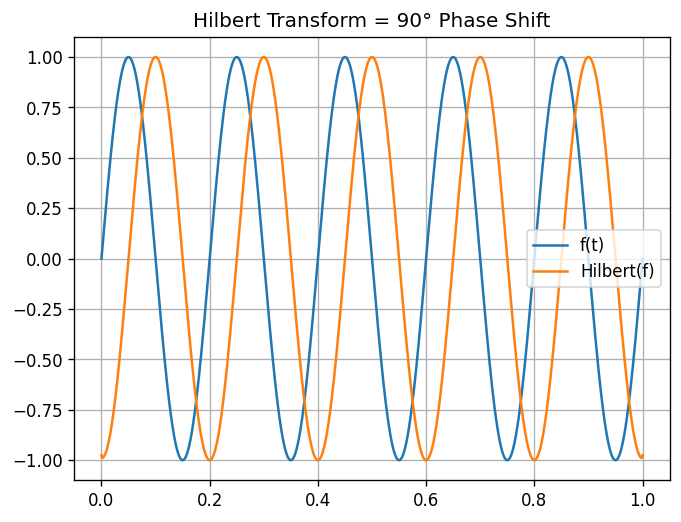

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

t = np.linspace(0, 1, 2000)
f = np.sin(2*np.pi*5*t)

hf = np.imag(hilbert(f))

plt.plot(t, f, label='f(t)')
plt.plot(t, hf, label='Hilbert(f)')
plt.legend()
plt.title('Hilbert Transform = 90° Phase Shift')
plt.show()


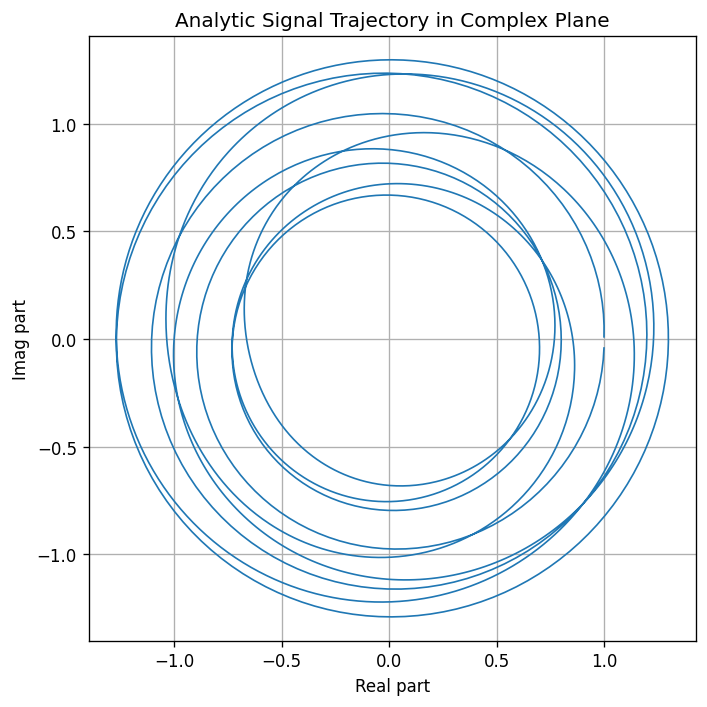

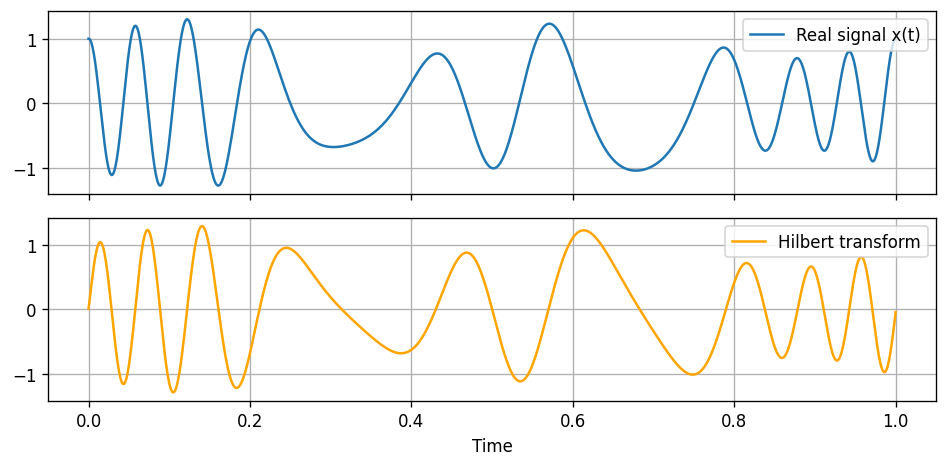

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Signal parameters
t = np.linspace(0, 1, 2000)
A = 1 + 0.3 * np.sin(2*np.pi*2*t)             # slow envelope
phi = 2*np.pi*(5*t + 2*np.sin(2*np.pi*1*t))  # FM modulation
x = A * np.cos(phi)

# Analytic signal
xa = hilbert(x)

# Plot for slide: complex-plane trajectory 
plt.figure(figsize=(6,6))
plt.plot(np.real(xa), np.imag(xa), linewidth=1.0)
plt.title("Analytic Signal Trajectory in Complex Plane")
plt.xlabel("Real part")
plt.ylabel("Imag part")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.savefig("analytic_spiral.png", dpi=300)
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(8,4), sharex=True)
ax[0].plot(t, x, label="Real signal x(t)")
ax[1].plot(t, np.imag(xa), label="Hilbert transform", color='orange')
ax[0].legend()
ax[1].legend()
ax[1].set_xlabel("Time")
plt.tight_layout()
plt.show()
